In [ ]:
## 以下脚本用于部署 Allin1 WebUI API

## 网关部署

In [1]:
%%bash
sudo chown -R ec2-user:ec2-user .
docker logout public.ecr.aws

Removing login credentials for public.ecr.aws


In [2]:
!git clone --recurse-submodules -j8 https://github.com/6congyao/stable-diffusion-webui-api-workshop.git

Cloning into 'stable-diffusion-webui-api'...
remote: Enumerating objects: 5117, done.
remote: Counting objects: 100% (977/977), done.
remote: Compressing objects: 100% (468/468), done.
remote: Total 5117 (delta 501), reused 957 (delta 486), pack-reused 4140
Receiving objects: 100% (5117/5117), 56.78 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (1374/1374), done.


In [ ]:
import boto3,os
account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/extras/deployment/')
s3uri = os.getenv('s3uri')
cmd = "/bin/sh ./build_and_deploy.sh s3://%s %s" %(s3uri,region_name)
os.system(cmd)

In [6]:
!aws s3 presign s3://$s3uri/templates/all-in-one-ai-lambda.yaml | cut -d '?' -f 1

https://aigc-eu-central-1-00e09f20.s3.amazonaws.com/templates/all-in-one-ai-lambda.yaml


In [7]:
cfn = "$(aws s3 presign s3://$s3uri/templates/all-in-one-ai-lambda.yaml | cut -d '?' -f 1)"

In [ ]:
!aws cloudformation create-stack --stack-name allin1ai-api --template-url $cfn --parameters ParameterKey=S3Bucket,ParameterValue=$s3uri ParameterKey=S3Key,ParameterValue="" --capabilities CAPABILITY_NAMED_IAM

In [10]:
!aws cloudformation describe-stacks --stack-name allin1ai-api --output json --query 'Stacks[0].StackStatus'

"CREATE_COMPLETE"


In [11]:
APIGW_URL="$(aws cloudformation describe-stacks --stack-name allin1ai-api --output text --query 'Stacks[0].Outputs[?OutputKey==`ApiGatewayProdEndpoint`].OutputValue')"

In [ ]:
!echo $APIGW_URL

## 节点部署

In [ ]:
#需要更新或者重新部署环境时执行
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/')
s3uri = os.getenv('s3uri')
cmd = "/bin/sh ./build_and_push.sh %s" %(region_name)
os.system(cmd)

In [16]:
## Deploy to SageMaker Asychronous Endpoint,需要部署新推理节点时执行

In [ ]:
model_data = "s3://{0}/stable-diffusion-webui/data/model.tar.gz".format(bucket)
!touch dummy
!tar czvf model.tar.gz dummy
!rm dummy
!aws s3 cp model.tar.gz $model_data

In [37]:
model_name = None
image_uri = "{0}.dkr.ecr.{1}.amazonaws.com/all-in-one-ai-stable-diffusion-webui-inference-api:latest".format(
    account_id, region_name
)

In [ ]:
#节点初始化模型方式1/3,通过修改json文件方式

In [38]:
import json

huggingface_models = [
    {
        "repo_id": "runwayml/stable-diffusion-v1-5",
        "filename": "v1-5-pruned.ckpt",
        "name": "Stable-diffusion",
    },
    {
        "repo_id": "lllyasviel/ControlNet",
        "filename": "models/control_sd15_canny.pth",
        "name": "ControlNet",
    },
]

http_models = [
    {
        "uri": "https://civitai.com/api/download/models/7627",
        "filename": "2bNierAutomataLora_v2b.safetensors",
        "name": "Lora",
    }
]

model_environment = {
    "ckpt": "/tmp/models/Stable-diffusion/v1-5-pruned.ckpt",
    "huggingface_models": json.dumps(huggingface_models),
    "http_models": json.dumps(http_models),
    "generated_images_s3uri": f"s3://{bucket}/stable-diffusion-webui/generated/",
    "embeddings_s3uri": f"s3://{bucket}/stable-diffusion-webui/embeddings/",
    "hypernetwork_s3uri": f"s3://{bucket}/stable-diffusion-webui/hypernetwork/",
}

In [ ]:
#节点初始化模型方式2/3,通过加载json文件方式

In [ ]:
!aws s3 sync /home/ec2-user/SageMaker/Allin1-Deploy/modelenvconfig s3://{bucket}/stable-diffusion-webui/modelenvconfig

In [ ]:
import json
model_environment = {
    "ckpt": "/tmp/models/Stable-diffusion/v1-5-pruned.ckpt",
    "generated_images_s3uri": f"s3://{bucket}/stable-diffusion-webui/generated/",
    "embeddings_s3uri": f"s3://{bucket}/stable-diffusion-webui/embeddings/",
    "hypernetwork_s3uri": f"s3://{bucket}/stable-diffusion-webui/hypernetwork/",
    "models_config_s3uri": f"s3://{bucket}/stable-diffusion-webui/modelenvconfig/models_config.json"
}


In [ ]:
#节点初始化模型方式3/3,通过S3存储桶动态加载

如果启动时只选机型和数量，则可以通过动态加载默认S3中的模型⽂件。 Sagemaker节点启动成功后, 每30s从默认的s3 位置s3://sagemaker-{region_name}- {account_id}/stable-diffusion-webui/models/同步模型⽂件到sagemaker节点的本地⽬录下。⽀ 持Stable-diffusion, Lora, ControlNet模型的动态加载同步。如：
• s3://$bucket/stable-diffusion-webui/models/Stable-diffusion/
• s3://$bucket/stable-diffusion-webui/models/ControlNet/
• s3://$bucket/stable-diffusion-webui/models/Lora/

In [ ]:
#以下载特定lora文件示例,其他模型请下载到对应文件夹
%%bash
cd /home/ec2-user/SageMaker/Allin1-Deploy/models/Lora
wget https://huggingface.co/opsopus/taiwanDollLikeness/resolve/main/taiwanDollLikeness_v10.safetensors

In [ ]:
!aws s3 sync ./models s3://{bucket}/stable-diffusion-webui/models

In [ ]:
#开始执行节点部署过程

In [39]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor
role = sagemaker.get_execution_role()
model = Model(
    name=model_name,
    model_data=model_data,
    role=role,
    image_uri=image_uri,
    env=model_environment,
    predictor_cls=Predictor,
)

instance_type = "ml.g5.2xlarge"
instance_count = 1

In [40]:
from sagemaker.async_inference import AsyncInferenceConfig

async_config = AsyncInferenceConfig(
    output_path="s3://{0}/{1}/asyncinvoke/out/".format(bucket, "stable-diffusion-webui")
)

In [41]:
predictor = model.deploy(
    instance_type=instance_type,
    initial_instance_count=instance_count,
    volume_size_in_gb=225,
    container_startup_health_check_timeout=1800,
    async_inference_config=async_config,
)

------------------!

In [49]:
predp = "$(aws sagemaker list-endpoints --query 'Endpoints[].EndpointName' --output text)"

In [53]:
!echo $predp

all-in-one-ai-stable-diffusion-webui-in-2023-06-06-03-45-24-976


#### Http API访问地址

In [54]:
APIURL = " %s/inference?endpoint_name=%s" %(APIGW_URL,predp)

In [ ]:
!echo $APIURL

#### Test API

In [ ]:
%%bash
tee lora.json << END
{
    "task": "text-to-image",
    "model": "v1-5-pruned.ckpt",
    "txt2img_payload": {
        "enable_hr": false,
        "denoising_strength": 0,
        "firstphase_width": 0,
        "firstphase_height": 0,
        "hr_scale": 2,
        "hr_upscaler": "",
        "hr_second_pass_steps": 0,
        "hr_resize_x": 0,
        "hr_resize_y": 0,
        "prompt": "(yorha no. 2 type b), 1girl, blue eyes, white hair, no blindfold, baseball cap, simple background, red shirt, upper body, (masterpiece), short hair, mole under mouth, nier automata, parted lips, <lora:yorha_noDOT_2_type_b:0.5>",
        "styles": [""],
        "seed": 2045180904,
        "subseed": -1,
        "subseed_strength": 0,
        "seed_resize_from_h": -1,
        "seed_resize_from_w": -1,
        "sampler_name": "",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 9,
        "width": 512,
        "height": 512,
        "restore_faces": false,
        "tiling": false,
        "do_not_save_samples": false,
        "do_not_save_grid": false,
        "negative_prompt": "skirt, (painting by bad-artist-anime:0.9), (painting by bad-artist:0.9), watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, artist name, (worst quality, low quality:1.4), bad anatomy",
        "eta": 0,
        "s_churn": 0,
        "s_tmax": 0,
        "s_tmin": 0,
        "s_noise": 1,
        "override_settings": {},
        "override_settings_restore_afterwards": true,
        "script_args": [],
        "sampler_index": "DPM++ SDE Karras",
        "script_name": "",
        "send_images": true,
        "save_images": false,
        "alwayson_scripts": {}
    }
}
END

In [ ]:
!curl -X POST -H 'Content-Type: application/json' $APIURL --data '@/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/lora.json' 

## Generate images using Lora models

LoRA (Low-Rank Adaptation of Large Language Models) models have become the standard to extend the Stable Diffusion models. Let's use Lora model to generate images.

In [57]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    "task": "text-to-image",
    "model": "v1-5-pruned.ckpt",
    "txt2img_payload": {
        "enable_hr": False,
        "denoising_strength": 0,
        "hr_scale": 2,
        "hr_upscaler": "",
        "hr_second_pass_steps": 0,
        "hr_resize_x": 0,
        "hr_resize_y": 0,
        "prompt": "yorha no. 2 type b, 1girl, bangs, black blindfold, black dress, black gloves, black hairband, blindfold, blindfold removed, breasts, cleavage cutout, clothing cutout, commentary request, dress, gloves, hairband, half-closed eyes, hand up, highres, io (sinking=carousel), juliet sleeves, long sleeves, looking at viewer, medium breasts, mole, mole under mouth, nier (series), nier automata, no blindfold, parted lips, puffy sleeves, short hair, solo, thighhighs, turtleneck, upper body, white hair, bokeh <lora:2bNierAutomataLora_v2b:0.5>",
        "styles": [""],
        "seed": 2674865251,
        "subseed": -1,
        "subseed_strength": 0,
        "seed_resize_from_h": -1,
        "seed_resize_from_w": -1,
        "sampler_name": "",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 7,
        "width": 512,
        "height": 512,
        "restore_faces": False,
        "tiling": False,
        "do_not_save_samples": False,
        "do_not_save_grid": False,
        "negative_prompt": "(worst quality, low quality:1.3)",
        "eta": 0,
        "s_churn": 0,
        "s_tmax": 0,
        "s_tmin": 0,
        "s_noise": 1,
        "override_settings": {},
        "override_settings_restore_afterwards": True,
        "script_args": [],
        "sampler_index": "DPM++ SDE Karras",
        "script_name": "",
        "send_images": True,
        "save_images": False,
        "alwayson_scripts": {},
    },
}

prediction = predictor.predict_async(inputs)

In [58]:
import json
import io

s3_resource = boto3.resource("s3")


def get_bucket_and_key(s3uri):
    pos = s3uri.find("/", 5)
    bucket = s3uri[5:pos]
    key = s3uri[pos + 1 :]
    return bucket, key

In [ ]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

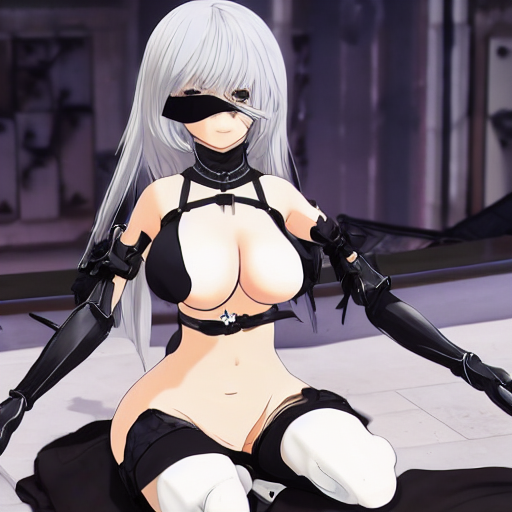

In [60]:
import traceback
from PIL import Image
import uuid
from datetime import datetime

try:
    output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    output_obj = s3_resource.Object(output_bucket, output_key)
    body = output_obj.get()["Body"].read().decode("utf-8")
    for image_uri in json.loads(body)["images"]:
        image_bucket, image_key = get_bucket_and_key(image_uri)
        image_object = s3_resource.Object(image_bucket, image_key)
        image = Image.open(io.BytesIO(image_object.get()["Body"].read()))
        image.show()
        image.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.jpg"))
except Exception as e:
    traceback.print_exc()
    print(e)

## Generate images using ControlNet models
ControlNet is a neural network structure to control diffusion models by adding extra conditions.

In [61]:
from PIL import Image
import base64
import io


def encode_image_to_base64(image):
    with io.BytesIO() as output_bytes:
        image.save(output_bytes, format="JPEG")
        bytes_data = output_bytes.getvalue()

    encoded_string = base64.b64encode(bytes_data)

    base64_str = str(encoded_string, "utf-8")
    mimetype = "image/jpeg"
    image_encoded_in_base64 = (
        "data:" + (mimetype if mimetype is not None else "") + ";base64," + base64_str
    )
    return image_encoded_in_base64


def decode_base64_to_image(encoding):
    if encoding.startswith("data:image/"):
        encoding = encoding.split(";")[1].split(",")[1]
    try:
        image = Image.open(io.BytesIO(base64.b64decode(encoding)))
        return image
    except Exception as e:
        print(e)

In [ ]:
from PIL import Image

image = Image.open("./images/inference/ControlNet/bal-source.png").convert("RGB")

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    "task": "text-to-image",
    "model": "v1-5-pruned.ckpt",
    "txt2img_payload": {
        "enable_hr": False,
        "denoising_strength": 0,
        "hr_scale": 2,
        "hr_upscaler": "",
        "hr_second_pass_steps": 0,
        "hr_resize_x": 0,
        "hr_resize_y": 0,
        "prompt": "ballon",
        "styles": [""],
        "seed": -1,
        "subseed": -1,
        "subseed_strength": 0,
        "seed_resize_from_h": -1,
        "seed_resize_from_w": -1,
        "sampler_name": "",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 7,
        "width": 512,
        "height": 512,
        "restore_faces": False,
        "tiling": False,
        "do_not_save_samples": False,
        "do_not_save_grid": False,
        "negative_prompt": "",
        "eta": 0,
        "s_churn": 0,
        "s_tmax": 0,
        "s_tmin": 0,
        "s_noise": 1,
        "override_settings": {},
        "override_settings_restore_afterwards": True,
        "script_args": [],
        "sampler_index": "DPM++ SDE Karras",
        "script_name": "",
        "send_images": True,
        "save_images": False,
        "alwayson_scripts": {
            "controlnet": {
                "args": [
                    {
                        "enabled": True,
                        "module": "none",
                        "model": "control_sd15_canny [fef5e48e]",
                        "weight": 1,
                        "image": encode_image_to_base64(image),
                        "low_vram": False,
                        "processor_res": 64,
                        "threshold_a": 64,
                        "threshold_b": 64,
                        "guidance_start": 0,
                        "guidance_end": 1,
                        "guess_mode": False,
                    }
                ]
            }
        },
    },
}

prediction = predictor.predict_async(inputs)

In [ ]:
from sagemaker.async_inference.waiter_config import WaiterConfig

print(f"Response object: {prediction}")
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
    max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
)

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")

In [ ]:
import traceback
from PIL import Image
import uuid
from datetime import datetime

try:
    output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    output_obj = s3_resource.Object(output_bucket, output_key)
    body = output_obj.get()["Body"].read().decode("utf-8")
    for image_uri in json.loads(body)["images"]:
        image_bucket, image_key = get_bucket_and_key(image_uri)
        image_object = s3_resource.Object(image_bucket, image_key)
        image = Image.open(io.BytesIO(image_object.get()["Body"].read()))
        image.show()
        image.save(datetime.now().strftime(f"%Y%m%d%H%M%S-{uuid.uuid4()}.jpg"))
except Exception as e:
    traceback.print_exc()
    print(e)

### [可选]基于实例排队的任务数量(ApproximateBacklogSizePerInstance)配置推理节点的自动伸缩,
如果配置了多节点需要手动指定Endpoint name.

In [ ]:
def create_autoscaling_group_for_sagemaker_endpoint(
    endpoint_name, min_capcity=1, max_capcity=2, target_value=5
):
    # application-autoscaling client
    asg_client = boto3.client("application-autoscaling")

    # This is the format in which application autoscaling references the endpoint
    resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

    # Configure Autoscaling on asynchronous endpoint down to zero instances
    response = asg_client.register_scalable_target(
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        MinCapacity=min_capcity,
        MaxCapacity=max_capcity,
    )

    response = asg_client.put_scaling_policy(
        PolicyName=f"Request-ScalingPolicy-{endpoint_name}",
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
        PolicyType="TargetTrackingScaling",
        TargetTrackingScalingPolicyConfiguration={
            "TargetValue": target_value,
            "CustomizedMetricSpecification": {
                "MetricName": "ApproximateBacklogSizePerInstance",
                "Namespace": "AWS/SageMaker",
                "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
                "Statistic": "Average",
            },
            "ScaleInCooldown": 600,  # duration until scale in begins (down to zero)
            "ScaleOutCooldown": 300,  # duration between scale out attempts
        },
    )


create_autoscaling_group_for_sagemaker_endpoint(predictor.endpoint_name)

In [ ]:
#压力测试(需要修改multi-process-client.py相关部分)
#在Terminal 中执行 python multi-process-master.py 100 1

In [ ]:
#查看相关弹性活动日志

In [ ]:
!aws application-autoscaling describe-scaling-activities \
    --service-namespace sagemaker \
    --resource-id endpoint/$predp/variant/AllTraffic

### Payload测试

In [ ]:
import json
import os
rawjson = {
    "task": "text-to-image",
    "model": "v1-5-pruned.ckpt",
    "txt2img_payload": {
        "enable_hr": False,
        "denoising_strength": 0,
        "hr_scale": 2,
        "hr_upscaler": "",
        "hr_second_pass_steps": 0,
        "hr_resize_x": 0,
        "hr_resize_y": 0,
        "prompt": "man on the hill",
        "styles": [""],
        "seed": -1,
        "subseed": -1,
        "subseed_strength": 0,
        "seed_resize_from_h": -1,
        "seed_resize_from_w": -1,
        "sampler_name": "",
        "batch_size": 1,
        "n_iter": 1,
        "steps": 20,
        "cfg_scale": 7,
        "width": 512,
        "height": 512,
        "restore_faces": False,
        "tiling": False,
        "do_not_save_samples": False,
        "do_not_save_grid": False,
        "negative_prompt": "",
        "eta": 0,
        "s_churn": 0,
        "s_tmax": 0,
        "s_tmin": 0,
        "s_noise": 1,
        "override_settings": {},
        "override_settings_restore_afterwards": True,
        "script_args": [],
        "sampler_index": "DPM++ SDE Karras",
        "script_name": "",
        "send_images": True,
        "save_images": False,
        "alwayson_scripts": {
            "controlnet": {
                "args": [
                    {
                        "enabled": True,
                        "module": "none",
                        "model": "control_sd15_canny [fef5e48e]",
                        "weight": 1,
                        "image": "https://painting-1251215091.cos.ap-shanghai.myqcloud.com/api/2023_05_23/20230523105334783830_e7d55f25dec7f9e7a3174b936c1dd011.png",
                        "low_vram": False,
                        "processor_res": 64,
                        "threshold_a": 64,
                        "threshold_b": 64,
                        "guidance_start": 0,
                        "guidance_end": 1,
                        "guess_mode": False,
                    }
                ]
            }
        }
    }
}
json_object = json.dumps(rawjson, indent=4)
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/')
with open("lora2.json", "w") as outfile:
    outfile.write(json_object)


In [ ]:
!curl -X POST -H 'Content-Type: application/json' $APIURL --data '@/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/lora2.json' 

In [ ]:
#查看Predictor日志

In [ ]:
aws logs tail /aws/sagemaker/Endpoints/$predp --follow --region $region_name --since 1h

### 更新

In [ ]:
!git pull --recurse-submodules -j8

In [ ]:
1. 重新打包镜像

In [ ]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/')
s3uri = os.getenv('s3uri')
cmd = "/bin/sh ./build_and_push.sh %s" % (region_name)
os.system(cmd)

In [ ]:
2. Lambda 更新
 修改或更新stable-diffusion-webui-api/stable-diffusion-webui-api/extras/backend/src 下的文件

In [ ]:
import boto3
import os
account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name
os.chdir('/home/ec2-user/SageMaker/Allin1-Deploy/stable-diffusion-webui-api/extras/deployment/')
s3uri = os.getenv('s3uri')
#cmd = "/bin/sh ./update_lambda.sh -b %s -r %s -a" %(s3uri,region_name)
cmd = "/bin/sh ./update_lambda.sh -r %s -a" % (region_name)
os.system(cmd)

In [ ]:
#节点清理(注意:会删除推理节点)

In [ ]:
predictor.delete_endpoint()
